# Standard Curve Deconvolution

A standard curve of a chemical species is a serial dilution across different concentrations that is used to calculate extinction coefficients (also called molar absorptivity) using [Beer's Law]<(https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Instrumental_Analysis_(LibreTexts)/13%3A_Introduction_to_Ultraviolet_Visible_Absorption_Spectrometry/13.02%3A_Beer's_Law)> <br>
In the following experimental dataset, a 2-fold serial dilution was made of a new oxidized peptide mixture, oxHHGY, and the standard curve was measured via UV-Visible spectroscopy to calculate extinction coefficients for the novel absorbances. UV-vis absorbance bands are symmetrical and can be described mathematically by a Gaussian function. However, the experimental standard curve did not have distinct, symmetric bands, meaning that the absorbance bands are overlapped. Calculation of extinction coefficients from overlapped bands will lead to error, particularly leading to overestimation of sample concentrations.Therefore, this standard curve needs to be deconvoluted before accurate extinction coeeficients can be calculated. Deconvolution can also show the primary absorbing components of a mixture. <br>

In the "Individual_spectral_deconvolution" notebook, peaks were deconvoluted from simpler spectra containing 1-3 peaks. These simpler individual spectra together make the oxHHGY mixture, so the absorbances in the standard curve must arise from the individual separated spectra. Having these parameters in hand will allow for good guesses about the peaks in the overlapped standard curve.

### References consulted
-  Eric Monson, Ph.D., data visualization analyst at Duke University Libraries' Center for Data and Visualization Sciences
- https://stackoverflow.com/questions/54851012/fitting-data-with-multiple-gaussian-profiles-in-python
- [Excel for Chemists: a Comprehensive Guide by E. Joseph Billo, 1997, Chapter 19 Analysis of Spectrophotometric Data](https://afitch.sites.luc.edu/Articles/DeLevie%20Deconvolution%20spectra%20excel.pdf)

In [9]:
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

### The following peak parameters were obtained from the Indivual spectra deconvolution: 

1. Spectrum 12 [0.016, 275, 8.7]
2. Spectrum 14 [0.00404,320.8, 24.49882]
3. Spectrum 11 [0.00043, 308.00278, 30.49469]
4. Spectrum 17 [0.00000349, 319.1, 21.2]
5. Spectrum 20 [0.00000097, 305.5, 30.]
6. Spectrum 19 [0.0000025, 292, 11]
7. Spectrum 19 [0.0000009, 305.5, 30.2]
8. Spectrum 24 [0.00000295, 346.5, 23.6 ]
9. Spectrum 24 [0.00000145, 295, 13.]
10. Spectrum 28 [0.00304,333.00067, 28.]
11. Spectrum 28 [0.006, 412.50663, 35.78355]
<br>

Parameters from peaks 2 and 4, peaks 3, 5, and 7, and peaks 6 and 9 are very similar. These spectral features are probably arising from the same chemical structures in different peptide species. Therefore, these redundant peaks can be combined into one guessed peak to fit into the standard curve. <br><br>
__This leaves seven peaks:__
1. Spectrum 12 [ 275, 8.7]
2. Spectra 14/17 [319.1-320.8, 21.2-24.49]
3. Spectra 11/20/19 [305.5-308.00278, 30-30.49469]
4. Spectra 19/24 [292-295, 11-13]
5. Spectrum 24 [346.5, 23.6 ]
6. Spectrum 28 [333.00067, 28.]
7. Spectrum 28 [412.50663, 35.78355] 
   <br> _Height parameter was omitted for clarity. The multi-Gaussian model will estimate the height._

### Define the multi-Gaussian equation for seven peaks

In [5]:
def gaussian(x, A, x0, sig):
    return A*np.exp(-(x.astype(float)-x0)**2/(2*sig**2))

def multi_gaussian7(x, *pars):
    g1 = gaussian(x, pars[0], pars[1], pars[2])
    g2 = gaussian(x, pars[3], pars[4], pars[5])
    g3 = gaussian(x, pars[6], pars[7], pars[8])
    g4 = gaussian(x, pars[9], pars[10], pars[11])
    g5 = gaussian(x, pars[12], pars[13], pars[14])
    g6 = gaussian(x, pars[15], pars[16], pars[17])
    g7 = gaussian(x, pars[18], pars[19], pars[20])
    
    return g1 + g2 + g3 + g4 + g5 + g6 + g7


__Bring in the Standard Curve Data__ <br>
This is raw UVVis data from the standard curve of the oxHHGY peptide mixture. It represents a 2-fold serial dilution, so Dilution 1 is twice as concentrated as Dilution 2, which is twice as concentrated as Dilution 3 and so on. Dilution 6 is the least concentrated spectrum in the standard curve.

In [15]:
df = pd.read_excel('UVvis_data.xlsx', sheet_name='Standard Curve')
df

,Wavelength,Dilution 1,Dilution 2,Dilution 3,Dilution 4,Dilution 5,Dilution 6
0,250.9838,1.779291,0.908262,0.464133,0.245567,0.126200,0.067252
1,251.1415,1.770674,0.905496,0.463601,0.245367,0.125628,0.067113
2,251.2991,1.761136,0.900168,0.460582,0.243874,0.125075,0.066704
3,251.4568,1.752846,0.895720,0.458830,0.242800,0.124524,0.066579
4,251.6144,1.745723,0.892055,0.457077,0.242533,0.124281,0.066736
...,...,...,...,...,...,...,...
2268,599.5416,0.018347,0.011480,0.004282,0.006499,-0.000320,-0.001200
2269,599.6899,0.018087,0.011498,0.004142,0.007042,-0.000110,-0.001180
2270,599.8383,0.018334,0.011914,0.004976,0.007423,0.000444,-0.001170
2271,599.9866,0.018160,0.011589,0.004396,0.007270,0.000205,-0.001170


__Plotting standard curve to visualize experimental data to be fit__

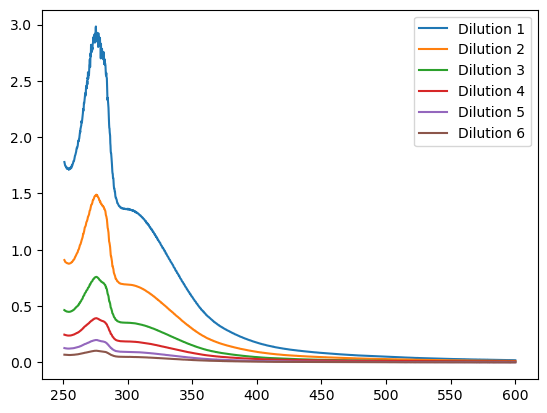

In [39]:
columns = df.columns[1:7]
for c in columns:
    plt.plot(df['Wavelength'], df[c], label = c)
    plt.legend()
plt.show()


### Deconvolution Protocol
-  The process to deconvolute the standard curve is similar to fitting the individual spectra in the first notebook. <br>
-  Make the intial guesses from the peak paramters calculated from the first notebook. 
-  Redundant spectra from multiple peaks will have wider bounds given to cover the small range of parameters. Peaks from one spectrum will have very narrow bounds to stay true to the actual absorbance.
-  Keep the height parameter upper and lower bounds for the inital guess wide open

In [10]:

guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.006, 295, 13 ,     0.0021, 333, 28.,      0.0039 , 412.5,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.0001, 319, 21.1 ,     0.0001, 305, 30.0 ,            0.0001, 346.4, 23.5,   0.0001, 292, 11,   0.0001, 332.9, 27.9,   0.0001, 412.4, 35.6)          
upper_bounds = (1,275.1, 8.7,         1, 321, 24.6  ,         1, 308.1 , 30.6   ,            1, 346.6, 23.7,       1, 295.1, 13.1,    1, 333.1, 28.1,         1, 412.6, 35.8  )

__Starting by fitting to Dilution 6 because it's the lowest concentration and should have low signal-to-noise__ <br>
Same as the previous notebook, this plot shows the cumulative fit (red dash) overlaid on the experimental data

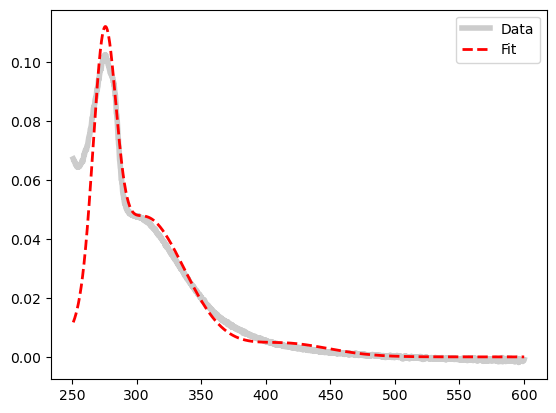

In [13]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 6'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 6'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

#### While this initial fit is pretty good, it can still use manual refinement. <br>
Particularly, peaks that arise from the same spectrum, like peaks 6 and 7, need to have the same relative absorbance to each other that they did in their individual spectrum.

In [16]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  0.08265988 275.           8.7       ]
[  0.0001 321.      24.6   ]
[  0.04694534 305.          30.6       ]
[  0.00210449 346.6         23.5       ]
[  0.0001 295.1     11.    ]
[  0.0001 333.1     28.1   ]
[  0.00470007 412.4         35.8       ]


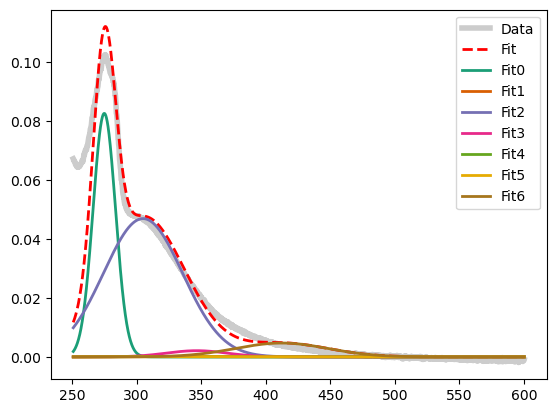

In [18]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 6'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))

plt.legend()
plt.show()


__Refining the bounds to better fit the experimental curve.__ <br>
In the original deconvolution os Spectrum 28, the 333 nm peak had an absorbance of 0.00304 au and the 412 nm had an absorbance of 0.006. Therefore the height of the 33 nm peaks needs to be manually adjusted to be about half of the 412 nm peak height.

In [50]:

guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.006, 295, 13 ,     0.0021, 333, 28.,      0.0039 , 412.50,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.0015, 319, 24.4 ,     0.0001, 305, 30.0 ,            0.006, 346.4, 23.5,   0.0029, 294.9, 13,  0.0018, 332.9, 27.9,   0.0001, 412.40, 35.6)          
upper_bounds = (0.08,275.1, 8.7,      1, 321, 24.6  ,         0.04, 308 , 30.6   ,            0.8, 346.6, 23.7,    0.8, 295.1, 13.1,    0.0022, 333.1, 28.1,     0.8, 412.60, 35.8  )

These guesses fit the curve better, but more importantly, the peak parameters are now adjusted to be more accurate to the "true" spectra of the chemical species present.

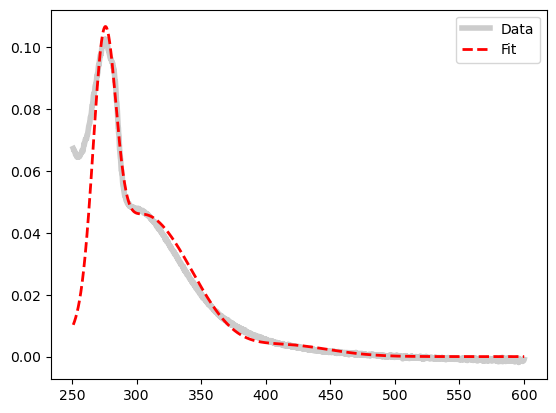

In [53]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 6'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 6'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

In [55]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  0.08 275.     8.7 ]
[  0.0015 319.      24.6   ]
[  0.04 305.    30.6 ]
[  0.006      346.6         23.50002199]
[  0.0029037 294.9        13.1      ]
[  0.0018 332.9     28.1   ]
[  0.0038228 412.4        35.6      ]


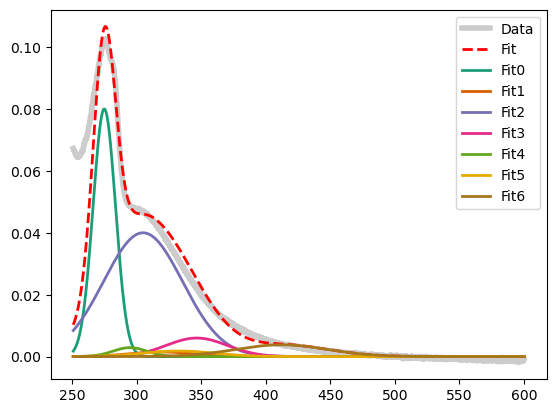

In [57]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 6'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))
plt.legend()
plt.show()


### Extracting XY Data from a Plot <br>
The Fits calculated here in Python will be plotted in another graphing program, but the XY data for these lines is needed to do that. Instead of "extracting" from the plotted data, a data frame can be made from the calculated fits directly. A dictionary defines each of the fits first so that it's easier to write the code to create the data frame. <br>
1. To define the y data for each fit, use the same code that plotted the y data <br>
    1. For the red dashed cumulative fit `multigaussian7(xx, *popt)` is used <br>
    2. For the seven individual fits, the code from the `for` loop is used `gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2])`<br> 
Replace the gg variable with the fit number.

In [103]:
Fits = {'Total Fit':multi_gaussian7(xx, *popt),
        'Fit1':gaussian(xx,popt[0*3],popt[0*3+1],popt[0*3+2]),
        'Fit2':gaussian(xx,popt[1*3],popt[1*3+1],popt[1*3+2]),
        'Fit3':gaussian(xx,popt[2*3],popt[2*3+1],popt[2*3+2]),
        'Fit4':gaussian(xx,popt[3*3],popt[3*3+1],popt[3*3+2]),
        'Fit5':gaussian(xx,popt[4*3],popt[4*3+1],popt[4*3+2]),
        'Fit6':gaussian(xx,popt[5*3],popt[5*3+1],popt[5*3+2]),
        'Fit7':gaussian(xx,popt[6*3],popt[6*3+1],popt[6*3+2])}

2. Create the data frame from the dictionary.
3. Change the data frame index to the Wavelength variable to have the correct X match the Y data

In [108]:
Decon_Dil6 = pd.DataFrame(Fits)
Decon_Dil6.index=xx
Decon_Dil6

,Total Fit,Fit1,Fit2,Fit3,Fit4,Fit5,Fit6,Fit7
Wavelength,,,,,,,,
250.9838,1.026461e-02,1.771620e-03,3.281621e-05,8.422036e-03,1.742561e-06,1.051954e-05,2.569874e-05,1.772639e-07
251.1415,1.043355e-02,1.862217e-03,3.340236e-05,8.498891e-03,1.789968e-06,1.095196e-05,2.612222e-05,1.807378e-07
251.2991,1.060688e-02,1.956742e-03,3.399720e-05,8.576170e-03,1.838553e-06,1.140022e-05,2.655157e-05,1.842740e-07
251.4568,1.078496e-02,2.055456e-03,3.460160e-05,8.653971e-03,1.888405e-06,1.186540e-05,2.698741e-05,1.878781e-07
251.6144,1.096769e-02,2.158373e-03,3.521491e-05,8.732197e-03,1.939490e-06,1.234747e-05,2.742926e-05,1.915468e-07
...,...,...,...,...,...,...,...,...
599.5416,6.466129e-09,5.363692e-304,8.613591e-32,3.041839e-22,1.062369e-27,1.070046e-120,5.046483e-23,6.466129e-09
599.6899,6.331214e-09,2.839507e-304,8.041164e-32,2.903164e-22,9.936709e-28,8.223210e-121,4.799917e-23,6.331214e-09
599.8383,6.198923e-09,1.502137e-304,7.506157e-32,2.770659e-22,9.293373e-28,6.317534e-121,4.565116e-23,6.198923e-09


4. Exporting the data to a CSV file 
Change the `Path` to correspond to the folder and name the .csv file is saved. The file should immediately appear in that folder.

In [ ]:
from pathlib import Path 
filepath = Path('C:/Your_directory/Your_file/filename.csv')
Deconv_Dil6.to_csv(filepath)

__Continue fitting the other dilutions of the standard curve using the same process.__ <br>
Since the data is a 2-fold serial dilution, the next dilution should should have the same peaks roughly doubled in intensity. For clarity, only the final guess and bounds parameters leading to the best fit are shown for the rest of the Dilutions.

In [59]:
# Fitting the 5th Dilution of the Standard Curve

guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.006, 295, 13 ,     0.004, 333, 28.,      0.0039 , 412.50,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.003, 319, 24.4 ,     0.0001, 305, 30.0 ,            0.012, 346.4, 23.5,   0.0059, 294.9, 13,  0.0035, 332.9, 27.9,        0.0001, 412.40, 35.6)          
upper_bounds = (0.155,275.1, 8.7,      1, 321, 24.6  ,         0.078, 308 , 30.6   ,        0.8, 346.6, 23.7,    0.8, 295.1, 13.1,    0.004, 333.1, 28.1,     0.007, 412.60, 35.8 )

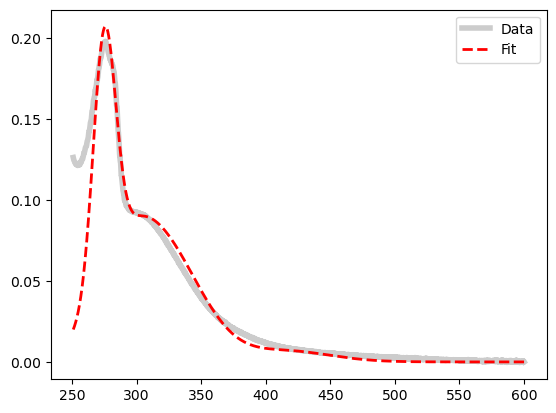

In [61]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 5'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 5'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

In [63]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  0.155 275.      8.7  ]
[  0.003 319.     24.6  ]
[  0.078 305.     30.6  ]
[  0.012      346.6         23.69999956]
[  0.0059 294.9     13.1   ]
[  0.0035 332.9     28.1   ]
[  0.007      412.6         35.79999998]


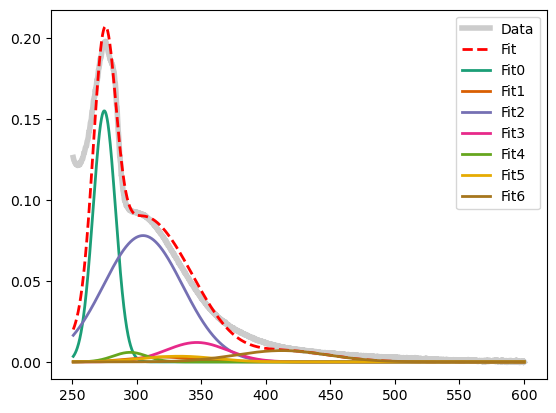

In [65]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 5'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))
plt.legend()
plt.show()


In [67]:
Fits = {'Total Fit':multi_gaussian7(xx, *popt),
        'Fit1':gaussian(xx,popt[0*3],popt[0*3+1],popt[0*3+2]),
        'Fit2':gaussian(xx,popt[1*3],popt[1*3+1],popt[1*3+2]),
        'Fit3':gaussian(xx,popt[2*3],popt[2*3+1],popt[2*3+2]),
        'Fit4':gaussian(xx,popt[3*3],popt[3*3+1],popt[3*3+2]),
        'Fit5':gaussian(xx,popt[4*3],popt[4*3+1],popt[4*3+2]),
        'Fit6':gaussian(xx,popt[5*3],popt[5*3+1],popt[5*3+2]),
        'Fit7':gaussian(xx,popt[6*3],popt[6*3+1],popt[6*3+2])}
Deconv_Dil5 = pd.DataFrame(Fits)
Deconv_Dil5.index = xx
Deconv_Dil5

,Total Fit,Fit1,Fit2,Fit3,Fit4,Fit5,Fit6,Fit7
Wavelength,,,,,,,,
250.9838,1.999626e-02,3.432513e-03,6.563242e-05,1.642297e-02,3.505430e-06,2.140182e-05,4.996977e-05,2.628100e-07
251.1415,2.032463e-02,3.608045e-03,6.680472e-05,1.657284e-02,3.600729e-06,2.228158e-05,5.079321e-05,2.680860e-07
251.2991,2.066151e-02,3.791189e-03,6.799440e-05,1.672353e-02,3.698392e-06,2.319354e-05,5.162806e-05,2.734591e-07
251.4568,2.100759e-02,3.982445e-03,6.920320e-05,1.687524e-02,3.798601e-06,2.413995e-05,5.247552e-05,2.789381e-07
251.6144,2.136270e-02,4.181847e-03,7.042982e-05,1.702778e-02,3.901285e-06,2.512071e-05,5.333466e-05,2.845177e-07
...,...,...,...,...,...,...,...,...
599.5416,8.395148e-09,1.039215e-303,1.722718e-31,5.931585e-22,2.212914e-27,2.176990e-120,9.812607e-23,8.395148e-09
599.6899,8.215430e-09,5.501545e-304,1.608233e-31,5.661170e-22,2.069915e-27,1.672998e-120,9.333172e-23,8.215430e-09
599.8383,8.039304e-09,2.910390e-304,1.501231e-31,5.402785e-22,1.935994e-27,1.285291e-120,8.876615e-23,8.039304e-09


In [19]:
from pathlib import Path
filepath = Path('C:/folder/filename.csv')
Deconv_Dil5.to_csv(filepath)

In [69]:
# Fitting the 4th Dilution of the Standard Curve

guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.015, 295, 13 ,     0.02, 333, 28.,      0.0039 , 412.50,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.006, 319, 24.4 ,     0.0001, 305, 30.0 ,            0.024, 346.4, 23.5,   0.011, 294.9, 13,    0.0126, 332.9, 27.9,        0.0001, 412.40, 35.6)          
upper_bounds = (0.3,275.1, 8.7,      1, 321, 24.6  ,         0.15, 308 , 30.6   ,                 0.8, 346.6, 23.7,    0.8, 295.1, 13.1,    0.5, 333.1, 28.1,     0.025, 412.60, 35.8  )

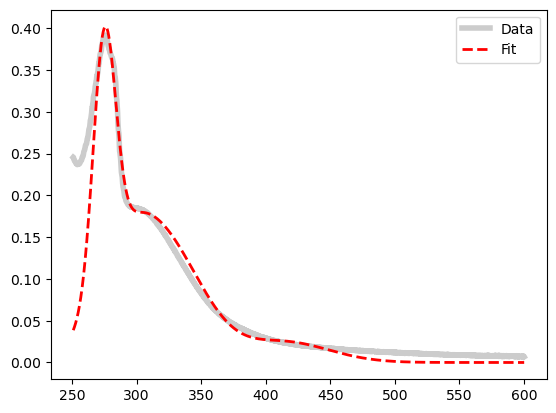

In [71]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 4'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 4'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

In [73]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  0.3 275.    8.7]
[  0.006 319.     24.6  ]
[  0.15 305.    30.6 ]
[  0.024 346.6    23.5  ]
[  0.01443389 294.9         13.1       ]
[  0.0126 332.9     28.1   ]
[  0.02499995 412.6         35.8       ]


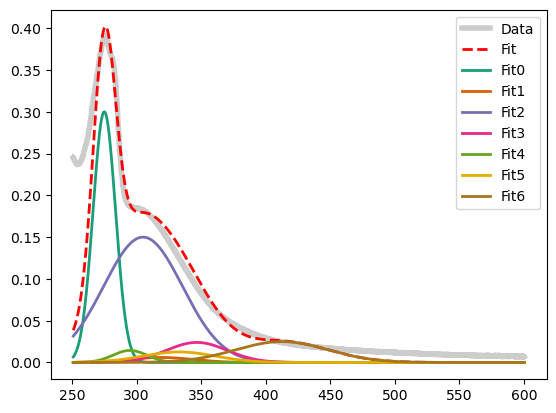

In [75]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 4'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))
plt.legend()
plt.show()


In [77]:
Fits = {'Total Fit':multi_gaussian7(xx, *popt),
        'Fit1':gaussian(xx,popt[0*3],popt[0*3+1],popt[0*3+2]),
        'Fit2':gaussian(xx,popt[1*3],popt[1*3+1],popt[1*3+2]),
        'Fit3':gaussian(xx,popt[2*3],popt[2*3+1],popt[2*3+2]),
        'Fit4':gaussian(xx,popt[3*3],popt[3*3+1],popt[3*3+2]),
        'Fit5':gaussian(xx,popt[4*3],popt[4*3+1],popt[4*3+2]),
        'Fit6':gaussian(xx,popt[5*3],popt[5*3+1],popt[5*3+2]),
        'Fit7':gaussian(xx,popt[6*3],popt[6*3+1],popt[6*3+2])}
Deconv_Dil4 = pd.DataFrame(Fits)
Deconv_Dil4.index = xx
Deconv_Dil4

,Total Fit,Fit1,Fit2,Fit3,Fit4,Fit5,Fit6,Fit7
Wavelength,,,,,,,,
250.9838,3.859676e-02,6.643573e-03,1.312648e-04,3.158264e-02,6.100351e-06,5.235791e-05,1.798912e-04,9.386053e-07
251.1415,3.923235e-02,6.983313e-03,1.336094e-04,3.187084e-02,6.269069e-06,5.451016e-05,1.828555e-04,9.574480e-07
251.2991,3.988443e-02,7.337784e-03,1.359888e-04,3.216064e-02,6.442052e-06,5.674122e-05,1.858610e-04,9.766378e-07
251.4568,4.055434e-02,7.707959e-03,1.384064e-04,3.245239e-02,6.619624e-06,5.905654e-05,1.889119e-04,9.962055e-07
251.6144,4.124177e-02,8.093898e-03,1.408596e-04,3.274574e-02,6.801668e-06,6.145587e-05,1.920048e-04,1.016133e-06
...,...,...,...,...,...,...,...,...
599.5416,2.998261e-08,2.011385e-303,3.445437e-31,1.140690e-21,1.671845e-27,5.325837e-120,3.532538e-22,2.998261e-08
599.6899,2.934076e-08,1.064815e-303,3.216466e-31,1.088686e-21,1.562025e-27,4.092860e-120,3.359942e-22,2.934076e-08
599.8383,2.871174e-08,5.633013e-304,3.002463e-31,1.038997e-21,1.459295e-27,3.144366e-120,3.195581e-22,2.871174e-08


In [25]:
from pathlib import Path
filepath = Path('C:/folder/filename.csv')
Deconv_Dil4.to_csv(filepath)

In [104]:
# Fitting the 3rd Dilution of the Standard Curve


guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.05, 295, 13 ,     0.02, 333, 28.,      0.0039 , 412.5,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.010, 319, 24.4 ,     0.0001, 305, 30.0 ,            0.045, 346.4, 23.5,   0.022, 294.9, 13,    0.017, 332.9, 27.9,        0.0001, 412.4, 35.6)          
upper_bounds = (0.6,275.1, 8.7,      1, 321, 24.6  ,         0.3, 308 , 30.6   ,                 0.8, 346.6, 23.7,    0.8, 295.1, 13.1,    0.5, 333.1, 28.1,     0.035, 412.6, 35.8  )

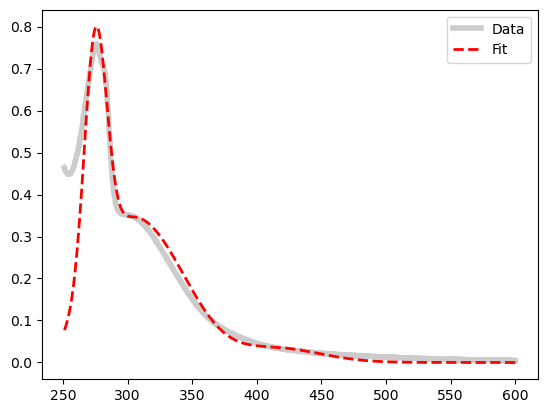

In [106]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 3'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 3'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

In [108]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  0.6 275.    8.7]
[  0.01 319.    24.6 ]
[  0.3 305.   30.6]
[  0.045 346.6    23.5  ]
[  0.022 294.9    13.1  ]
[  0.017 332.9    28.1  ]
[  0.03499999 412.6         35.6       ]


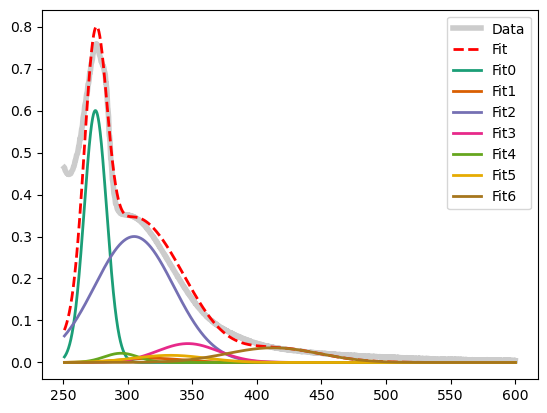

In [110]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 3'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))
plt.legend()
plt.show()


In [97]:
Fits = {'Total Fit':multi_gaussian7(xx, *popt),
        'Fit1':gaussian(xx,popt[0*3],popt[0*3+1],popt[0*3+2]),
        'Fit2':gaussian(xx,popt[1*3],popt[1*3+1],popt[1*3+2]),
        'Fit3':gaussian(xx,popt[2*3],popt[2*3+1],popt[2*3+2]),
        'Fit4':gaussian(xx,popt[3*3],popt[3*3+1],popt[3*3+2]),
        'Fit5':gaussian(xx,popt[4*3],popt[4*3+1],popt[4*3+2]),
        'Fit6':gaussian(xx,popt[5*3],popt[5*3+1],popt[5*3+2]),
        'Fit7':gaussian(xx,popt[6*3],popt[6*3+1],popt[6*3+2])}
Deconv_Dil3 = pd.DataFrame(Fits)
Deconv_Dil3.index = xx
Deconv_Dil3

,Total Fit,Fit1,Fit2,Fit3,Fit4,Fit5,Fit6,Fit7
Wavelength,,,,,,,,
250.9838,7.700632e-02,1.328715e-02,2.187747e-04,6.316527e-02,1.143816e-05,7.980341e-05,2.427103e-04,1.171515e-06
251.1415,7.827373e-02,1.396662e-02,2.226824e-04,6.374168e-02,1.175450e-05,8.308385e-05,2.467099e-04,1.195301e-06
251.2991,7.957404e-02,1.467557e-02,2.266480e-04,6.432127e-02,1.207885e-05,8.648440e-05,2.507648e-04,1.219531e-06
251.4568,8.090993e-02,1.541592e-02,2.306773e-04,6.490478e-02,1.241180e-05,9.001339e-05,2.548811e-04,1.244243e-06
251.6144,8.228079e-02,1.618780e-02,2.347661e-04,6.549148e-02,1.275313e-05,9.367044e-05,2.590541e-04,1.269415e-06
...,...,...,...,...,...,...,...,...
599.5416,3.599834e-08,4.022769e-303,5.742394e-31,2.281379e-21,3.134709e-27,8.117587e-120,4.766123e-22,3.599834e-08
599.6899,3.521913e-08,2.129630e-303,5.360776e-31,2.177373e-21,2.928798e-27,6.238297e-120,4.533255e-22,3.521913e-08
599.8383,3.445567e-08,1.126603e-303,5.004105e-31,2.077994e-21,2.736178e-27,4.792612e-120,4.311499e-22,3.445567e-08


In [207]:
from pathlib import Path
filepath = Path('C:/folder/file.csv')
Deconv_Dil3.to_csv(filepath)

In [112]:
# Fitting the 2nd Dilution of the Standard Curve


guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.05, 295, 13 ,     0.05, 333, 28.,      0.0039 , 412.5,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.020, 319, 24.4 ,     0.0001, 305, 30.0 ,            0.05, 346.4, 23.5,   0.024, 294.9, 13,    0.035, 332.9, 27.9,        0.0001, 412.4, 35.6)          
upper_bounds = (1.15,275.1, 8.7,      1, 321, 24.6  ,         0.6, 308 , 30.6   ,                 0.8, 346.6, 23.7,    0.8, 295.1, 13.1,    0.5, 333.1, 28.1,     0.070, 412.6, 35.8  )

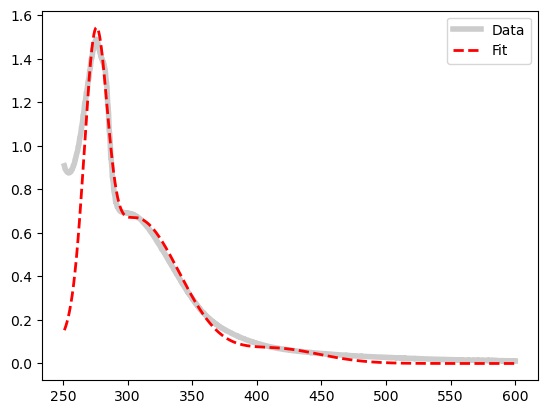

In [114]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 2'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 2'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

In [115]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  1.15 275.     8.7 ]
[  0.02 319.    24.6 ]
[  0.6 305.   30.6]
[  0.05 346.6   23.7 ]
[  0.024 294.9    13.1  ]
[  0.035 333.1    28.1  ]
[  0.07 412.4   35.8 ]


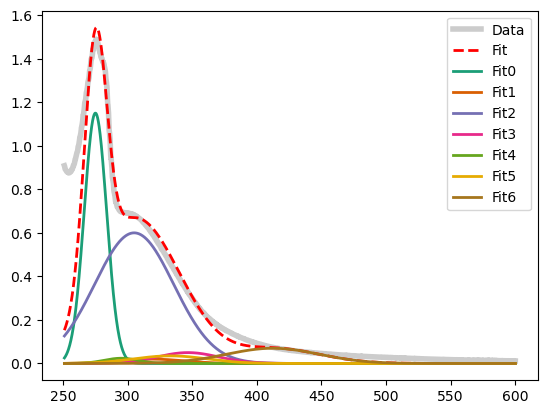

In [118]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 2'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))
plt.legend()
plt.show()


In [120]:
Fits = {'Total Fit':multi_gaussian7(xx, *popt),
        'Fit1':gaussian(xx,popt[0*3],popt[0*3+1],popt[0*3+2]),
        'Fit2':gaussian(xx,popt[1*3],popt[1*3+1],popt[1*3+2]),
        'Fit3':gaussian(xx,popt[2*3],popt[2*3+1],popt[2*3+2]),
        'Fit4':gaussian(xx,popt[3*3],popt[3*3+1],popt[3*3+2]),
        'Fit5':gaussian(xx,popt[4*3],popt[4*3+1],popt[4*3+2]),
        'Fit6':gaussian(xx,popt[5*3],popt[5*3+1],popt[5*3+2]),
        'Fit7':gaussian(xx,popt[6*3],popt[6*3+1],popt[6*3+2])}
Deconv_Dil2 = pd.DataFrame(Fits)
Deconv_Dil2.index = xx
Deconv_Dil2

,Total Fit,Fit1,Fit2,Fit3,Fit4,Fit5,Fit6,Fit7
Wavelength,,,,,,,,
250.9838,1.528289e-01,2.546703e-02,4.375495e-04,1.263305e-01,1.460596e-05,8.705827e-05,4.894241e-04,2.695182e-06
251.1415,1.553040e-01,2.676936e-02,4.453648e-04,1.274834e-01,1.500304e-05,9.063693e-05,4.975091e-04,2.749221e-06
251.2991,1.578423e-01,2.812817e-02,4.532960e-04,1.286425e-01,1.540997e-05,9.434662e-05,5.057065e-04,2.804254e-06
251.4568,1.604490e-01,2.954718e-02,4.613547e-04,1.298096e-01,1.582751e-05,9.819642e-05,5.140280e-04,2.860368e-06
251.6144,1.631229e-01,3.102661e-02,4.695321e-04,1.309830e-01,1.625536e-05,1.021859e-04,5.224647e-04,2.917513e-06
...,...,...,...,...,...,...,...,...
599.5416,8.153653e-08,7.710307e-303,1.148479e-30,4.562758e-21,9.220493e-27,8.855551e-120,1.049795e-21,8.153653e-08
599.6899,7.978920e-08,4.081791e-303,1.072155e-30,4.354746e-21,8.624665e-27,6.805415e-120,9.985407e-22,7.978920e-08
599.8383,7.807684e-08,2.159321e-303,1.000821e-30,4.155988e-21,8.066660e-27,5.228304e-120,9.497301e-22,7.807684e-08


In [59]:
from pathlib import Path
filepath = Path('C:/folder/file.csv')
Deconv_Dil2.to_csv(filepath)

In [130]:
# Fitting the 1st Dilution of the Standard Curve


guess =        [0.075,275., 8.7,     0.06, 320.8, 24.5  ,   0.004 , 306, 30.5 ,              0.3, 346.5, 23.6,     0.05, 295, 13 ,     0.07, 333, 28.,      0.0039 , 412.5,  35.7]
lower_bounds = (0.0001,275, 8.69,    0.040, 319, 24.4 ,     0.0001, 305, 30.0 ,            0.1, 346.4, 23.5,   0.049, 294.9, 13,    0.068, 332.9, 27.9,        0.0001, 412.4, 35.6)          
upper_bounds = (2.2,275.1, 8.7,      2, 321, 24.6  ,         1.2, 308 , 30.6   ,                 2, 346.6, 23.7,    2, 295.1, 13.1,    2, 333.1, 28.1,              0.135, 412.6, 35.8  )

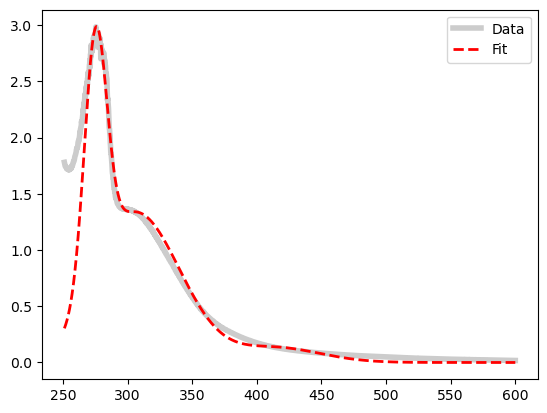

In [132]:
popt, pcov = curve_fit(multi_gaussian7, df['Wavelength'], df['Dilution 1'], guess, bounds=(lower_bounds,upper_bounds))
plt.figure()
plt.plot(df['Wavelength'], df['Dilution 1'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(df['Wavelength'], multi_gaussian7(df['Wavelength'], *popt), 'r--', linewidth=2, label='Fit')
plt.legend()
plt.show()

In [133]:
np.set_printoptions(precision=8, suppress=True)
print(popt[0:3])
print(popt[3:6])
print(popt[6:9])
print(popt[9:12])
print(popt[12:15])
print(popt[15:18])
print(popt[18:21])


[  2.2 275.    8.7]
[  0.04 319.    24.6 ]
[  1.2 305.   30.6]
[  0.1 346.6  23.7]
[  0.049 294.9    13.1  ]
[  0.068 332.9    28.1  ]
[  0.135 412.4    35.8  ]


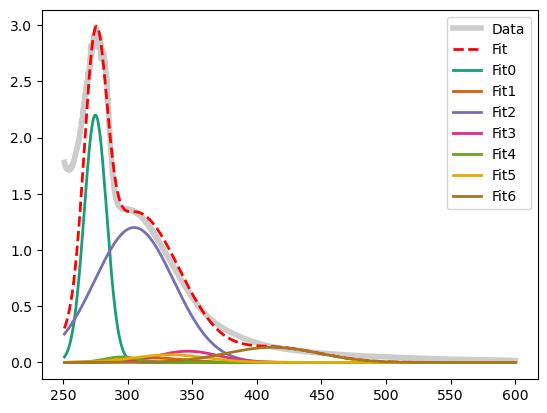

In [136]:
xx = df['Wavelength']
plt.plot(xx, df['Dilution 1'], '-', color='#CCCCCC', linewidth=4, label='Data')
plt.plot(xx, multi_gaussian7(xx, *popt), 'r--', linewidth=2, label='Fit')
for gg in range(7):
    plt.plot(xx, gaussian(xx,popt[gg*3],popt[gg*3+1],popt[gg*3+2]), '-', color=plt.cm.Dark2.colors[gg], linewidth=2, label='Fit'+str(gg))
plt.legend()
plt.show()


In [138]:
Fits = {'Total Fit':multi_gaussian7(xx, *popt),
        'Fit1':gaussian(xx,popt[0*3],popt[0*3+1],popt[0*3+2]),
        'Fit2':gaussian(xx,popt[1*3],popt[1*3+1],popt[1*3+2]),
        'Fit3':gaussian(xx,popt[2*3],popt[2*3+1],popt[2*3+2]),
        'Fit4':gaussian(xx,popt[3*3],popt[3*3+1],popt[3*3+2]),
        'Fit5':gaussian(xx,popt[4*3],popt[4*3+1],popt[4*3+2]),
        'Fit6':gaussian(xx,popt[5*3],popt[5*3+1],popt[5*3+2]),
        'Fit7':gaussian(xx,popt[6*3],popt[6*3+1],popt[6*3+2])}
Deconv_Dil1 = pd.DataFrame(Fits)
Deconv_Dil1.index = xx
Deconv_Dil1

,Total Fit,Fit1,Fit2,Fit3,Fit4,Fit5,Fit6,Fit7
Wavelength,,,,,,,,
250.9838,3.034387e-01,4.871954e-02,8.750989e-04,2.526611e-01,2.921193e-05,1.777440e-04,9.708412e-04,5.197851e-06
251.1415,3.082756e-01,5.121096e-02,8.907296e-04,2.549667e-01,3.000609e-05,1.850504e-04,9.868395e-04,5.302069e-06
251.2991,3.132340e-01,5.381042e-02,9.065920e-04,2.572851e-01,3.081994e-05,1.926244e-04,1.003059e-03,5.408203e-06
251.4568,3.183241e-01,5.652503e-02,9.227094e-04,2.596191e-01,3.165501e-05,2.004844e-04,1.019524e-03,5.516425e-06
251.6144,3.235432e-01,5.935525e-02,9.390642e-04,2.619659e-01,3.251072e-05,2.086296e-04,1.036216e-03,5.626632e-06
...,...,...,...,...,...,...,...,...
599.5416,1.572490e-07,1.475015e-302,2.296958e-30,9.125516e-21,1.844099e-26,1.808008e-119,1.906449e-21,1.572490e-07
599.6899,1.538792e-07,7.808644e-303,2.144310e-30,8.709492e-21,1.724933e-26,1.389439e-119,1.813302e-21,1.538792e-07
599.8383,1.505768e-07,4.130876e-303,2.001642e-30,8.311977e-21,1.613332e-26,1.067445e-119,1.724599e-21,1.505768e-07


In [147]:
from pathlib import Path
filepath = Path('C:/folder/file.csv')
Deconv_Dil1.to_csv(filepath)

## Conclusions
- The oxHHGY absorbance spectrum consists of three primary peaks:
> - Fit  0 (Fit 1 in exported data frame) centered at 275 nm
> - Fit 2 centered at 305 nm
> - Fit 6 centered at 412 nm
- The LC-MS data correlates absorbance spectrum of peptides with mass
> - Peptides that have peaks at 305 nm correlate to oxygenated and crosslinked structures.
> - The peptide with a peak at 412 nm correlates to oxygenated multimeric (dimers and trimers) structures.
- Therefore, the deconvolution process has answered the research question, "What gives rise to the observed novel absorbance?" by identifying specific oxygenations, intramolecular crosslinks, and intermolecular crosslinks as the major contributing structural modifications to absorbance. 


## Further analysis
<br>
- Solution concentration and extinction coefficients of each fit peak were calculated elsewhere with the exported XY data. Here are the protocols:
<br>

#### Calculating solution concentration
1. Gather the absorbance (height/intensity) of Fit 0 at 275 nm for each of the 6 Dilutions.
2. Using Beer's Law (A=elc), substitute the published extinction coefficient for Tyrosine at 275 nm (e275nm = 1405 1/M 1/cm) to solve for concentration _c_ in Molar units.
> Example : For Dilution 1, the height of Fit 0 is 2.2 at 275 nm. <br>
> 2.2 = 1405 * 1 (path length in cm) * c <br>
> 2.2 / 1405 = 0.001565 M <br>
> The concentration of the oxHHGY solution in Dilution 1 is 0.00156 M or 1.56 mM. <br>
3. Repeat these calculations for the other dilutions.

#### Calculating extinction coefficient of an unknown species

1. Plot the absorbance of a peak at the wavelength it's centered at (refered to as lambda max) against the solution concentration calculated previously.
2. Repeat for all dilutions.
3. Plot the trendline (simple linear regression) between these points with the line formula in y=mx+b format.
4. The slope (m) of the line is the extinction coefficient of that peak (given in 1/M 1/cm units).
   > The plot will look like this. The trendline equation is given for the three primary components in the standard curve, which contains the extinction coefficient. <br>

   ![Extinction Coefficient Plot](ExtCoeffPlot.jpg)